<a href="https://colab.research.google.com/github/cabamarcos/Captcha_recognition/blob/main/IAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

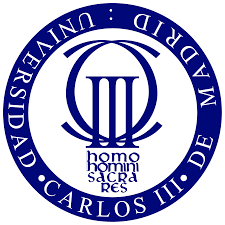

# PRÁCTICA FINAL: INTELIGENCIA ARTIFICIAL EN LAS ORGANIZACIONES

Pablo Hidalgo: 100451225.
Pablo Brasero: 100451247.
Miguel Castuera: 100451285.
Marcos Caballero: 100451047.   



# Introducción

# Importación de las herramientas necesarias

In [63]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from pathlib import Path


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow


# Análisis exploratorio de los datos

Según el creador de la publicación en kaggle, el dataset contiene palabras de 5 letras cada una.
Las palabras tienen ruido (blur y lineas).
Las imagenes PNG contienen 200x50 pixeles

Primero vamos a ver la naturaleza de los datos.
Para ello vamos a mostrarlos por pantalla.

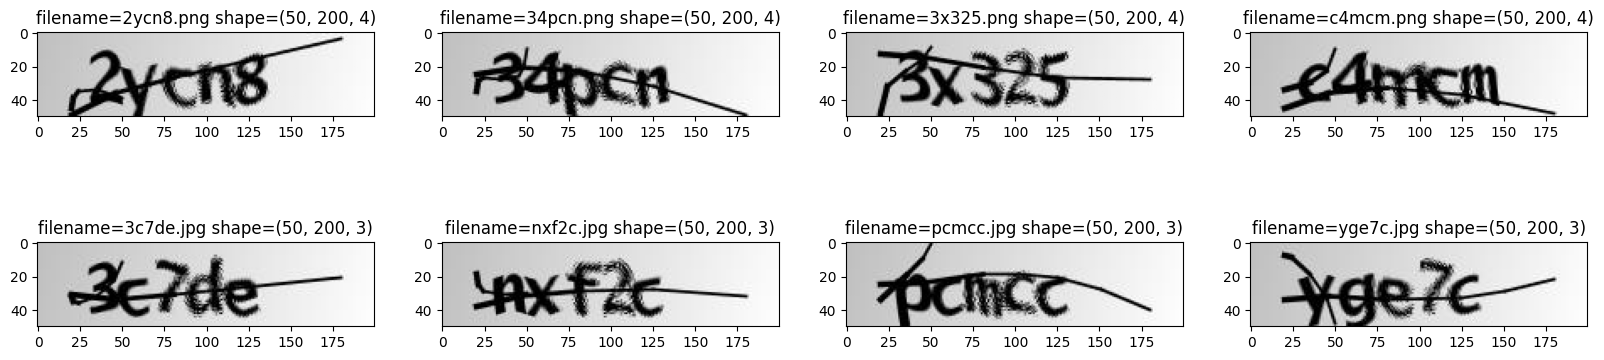

In [64]:
img_2ycn8 = mpimg.imread('2ycn8.png')
img_34pcn = mpimg.imread('34pcn.png')
img_3x325 = mpimg.imread('3x325.png')
img_c4mcm = mpimg.imread('c4mcm.png')
img_3c7de = mpimg.imread('3c7de.jpg')
img_nxf2c = mpimg.imread('nxf2c.jpg')
img_pcmcc = mpimg.imread('pcmcc.jpg')
img_yge7c = mpimg.imread('yge7c.jpg')
samples = {'2ycn8.png':img_2ycn8, '34pcn.png':img_34pcn, '3x325.png':img_3x325, 'c4mcm.png':img_c4mcm,
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'yge7c.jpg':img_yge7c}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

Como podemos ver, los nombres de las imágenes obviamente coincide con los caracteres de las imágenes.

Cabe destacar que al ver las imágenes, hemos notado que los numeros y letras se repiten notablemente, por lo que vamos a hacer un análisis para ver que caracteres se están utilizando, ya que nos puede ayudar en el futuro entrenamiento.

In [65]:
# Especifica la ruta a la carpeta que contiene las imágenes
image_folder = Path('/content/')

# Obtiene la lista de imágenes en la carpeta
images = list(image_folder.glob("*.png"))

# Store all the characters in a set
characters = set()

# Store all the labels in a set
labels = set()

# Create a list of dictionaries to store the image-label pair info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this captcha
    captcha_length = len(label)
    # 3. Store the image-label pair info
    dataset.append({"img_path": str(img_path), "label": label})
    # 4. Store the characters present
    characters.update(set(label))
    # 5. Store the labels
    labels.add(label)

# Convert the list of dictionaries into a DataFrame
dataset = pd.DataFrame(dataset)

print("Number of images found:", len(images))
print("Number of labels found:", len(labels))
print("Number of unique characters:", len(characters))
print("Characters present:", characters)


Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters present: {'b', '7', 'p', 'c', 'e', '6', '2', 'g', '3', 'x', 'n', 'f', '4', 'd', '5', '8', 'w', 'm', 'y'}


Como podemos ver, solo contiene 19 caracteres distintos, en vez de los 36 posibles si combinamos números y letras si excluimos la ñ, por lo que nuestro espacio de trabajo y búsqueda se ha reducido considerablemente.

Ahora vamos a ver con cuanta frecuencia se repite cada caracter

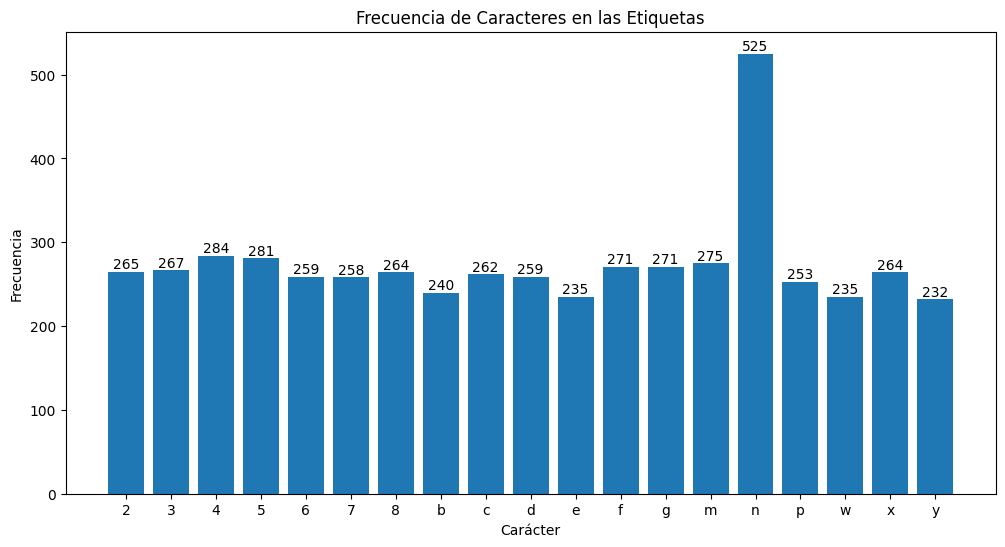

In [66]:
# Calcula la frecuencia de cada carácter
character_counts = Counter("".join(dataset["label"]))

# Convierte los resultados en dos listas separadas para plotear
characters = list(character_counts.keys())
counts = list(character_counts.values())

# Ordena los caracteres alfabéticamente
characters, counts = zip(*sorted(zip(characters, counts)))

# Crea la gráfica de barras
plt.figure(figsize=(12, 6))
plt.bar(characters, counts)

# Agrega etiquetas con el número exacto en cada barra
for i in range(len(characters)):
    plt.text(characters[i], counts[i], str(counts[i]), ha='center', va='bottom')

plt.xlabel("Carácter")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Caracteres en las Etiquetas")
plt.show()

Podemos ver que los datos son balanceados menos la n, la cual tiene el doble de datos que los demás. Aplicaremos las medidas necesarias para que los datos estén balanceados.

# 1ª estrategia

En esta estrategia, vamos a probar no realizar una preparación de los datos, para ver que tan bueno puede ser un modelo sin facilitarle las cosas

# 2ª estrategia

En esta estrategia vamos a segmentar las imágenes para poder evaluar caracter por caracter, de esta forma pretendemos entender ...

## Análisis visual de operaciones

En este apartado, vamos a intentar mostrar lo que vamos a realizar en el siguiente apartado.

Según podemos ver, nuestras imágenes tienen una linea que corta a la mayoría de caracteres, además, vemos que algunos caracteres están algo difuminados y distorsionados. Vamos a intentar eliminar la línea mediante operaciones en la imagen.

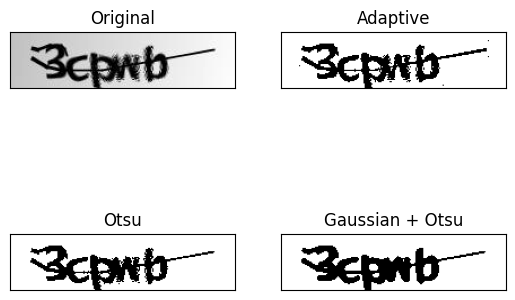

In [67]:
import cv2
import matplotlib.pyplot as plt

# Leer la imagen en escala de grises
image = cv2.imread('3cpwb.png', 0)

# Umbral adaptativo
adaptive_threshold = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 2)

# Umbral de Otsu
_, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Umbral de Otsu con desenfoque Gaussiano
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
_, gaussian_otsu_threshold = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, adaptive_threshold, otsu_threshold, gaussian_otsu_threshold]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()


Como podemos ver, las operaciones consiguen borrar el difuminado, pero no conseguimos borrar las lineas.

Vamos a probar otras operaciones, de forma que consiga borrar las líneas más finas.

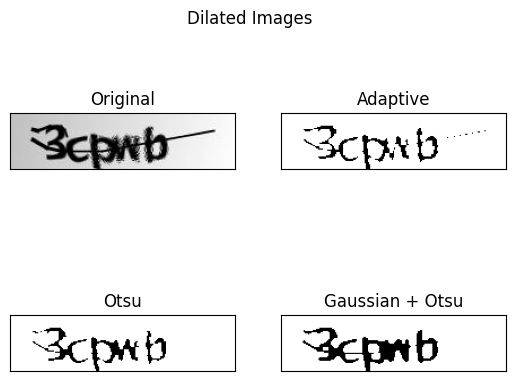

In [68]:
kernel = np.ones((3, 3), np.uint8)

# Aplicar dilatación a las imágenes umbralizadas
dilated_adaptive = cv2.dilate(adaptive_threshold, kernel, iterations=1)
dilated_otsu = cv2.dilate(otsu_threshold, kernel, iterations=1)
dilated_gaussian_otsu = cv2.dilate(gaussian_otsu_threshold, kernel, iterations=1)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, dilated_adaptive, dilated_otsu, dilated_gaussian_otsu]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.suptitle('Dilated Images')
plt.show()

Como podemos ver en este ejemplo, la linea se ha borrado casi por completo y las letras no son del todo ilegibles.

Vamos a ver si con otras operaciónes podemos generar una imagen con los caracteres algo más legibles.

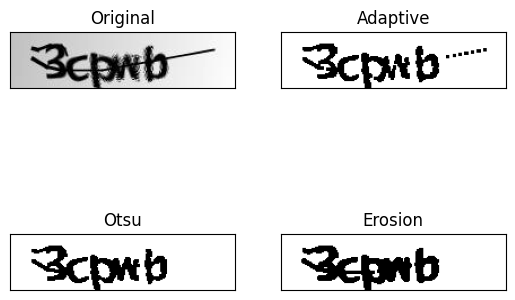

In [69]:
erosion_adaptive = cv2.erode(dilated_adaptive, kernel, iterations=1)
erosion_otsu = cv2.erode(dilated_otsu, kernel, iterations=1)
erosion_gaussian_otsu = cv2.erode(dilated_gaussian_otsu, kernel, iterations=1)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, erosion_adaptive, erosion_otsu, erosion_gaussian_otsu]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.title('Erosion')
plt.show()

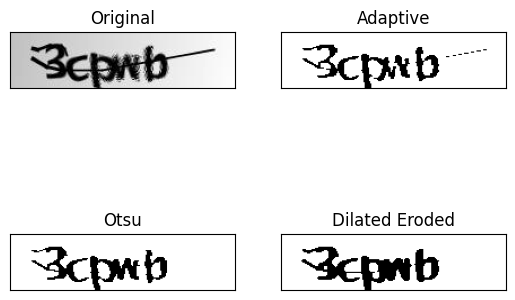

In [70]:
# Crear un nuevo kernel para la segunda dilatación
kernel2 = np.ones((3, 1), np.uint8)

# Aplicar una segunda dilatación a las imágenes erosionadas
dilated_erosion_adaptive = cv2.dilate(erosion_adaptive, kernel2, iterations=1)
dilated_erosion_otsu = cv2.dilate(erosion_otsu, kernel2, iterations=1)
dilated_erosion_gaussian_otsu = cv2.dilate(erosion_gaussian_otsu, kernel2, iterations=1)

# Gráficos
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [image, dilated_erosion_adaptive, dilated_erosion_otsu, dilated_erosion_gaussian_otsu]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.title('Dilated Eroded')
plt.show()

En este últumo ejemplo, podemos ver unas letras mucho más legibles, en la que la linea se ve mucho menos.

Gracias a estos ejemplos, podemos ver cómo mediante operaciones aplicadas a las imágenes, se pueden "limpiar" de forma que sea mucho más legible, eliminando las difuminaciones y suavizando las líneas.

## Aplicación de lo aprendido

Vamos a aplicar lo mostrado enn el apartado anterior, en todas y cada una de las imágenes que tenemos.

Primero vamos a definir las partes de las imágenes que no nos contienen datos en las imágenes, para luego aplicar el relleno de imagen con cv2

In [71]:
# Definir un kernel de convolución de 3x1 con valores enteros sin signo
kernel = np.ones((3, 1), np.uint8)

# Definir el tipo de borde a utilizar
borderType = cv2.BORDER_CONSTANT

# Función para aplicar relleno a una imagen
def pad(src):
    # Calcular la cantidad de píxeles de relleno para la parte superior e inferior
    top = int(0.05 * src.shape[0])  # El 5% de la altura de la imagen
    bottom = top

    # Calcular la cantidad de píxeles de relleno para la parte izquierda y derecha
    left = int(0.15 * src.shape[1])  # El 15% de la anchura de la imagen
    right = left

    # Aplicar el relleno a la imagen de origen utilizando cv2.copyMakeBorder
    des = cv2.copyMakeBorder(src, top, bottom, left + 1, right, borderType, None, 255)

    # Invertir los colores de la imagen utilizando cv2.bitwise_not
    return cv2.bitwise_not(des)

La siguiente parte del código, procesa una lista de imágenes utilizando la biblioteca OpenCV para aplicar umbralización adaptativa, dilatación y otras operaciones vistas en el apartado anterior, y luego recopila las imágenes resultantes en una lista x y sus etiquetas en una lista y.

In [72]:
images_dir = Path('/content/')
images = list(images_dir.glob("*.png"))

Vamos a ver un ejemplo de la operación aplicada a las imágenes antes de dividirla por caracteres

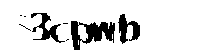

In [73]:
im = cv2.imread(str('3cpwb.png'), 0)

# Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

# Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
erosion = cv2.dilate(threshold, kernel, iterations=2)

cv2_imshow(erosion)


In [74]:
x = []  # Lista para almacenar las imágenes procesadas
y = []  # Lista para almacenar las etiquetas correspondientes

# Iterar a través de la lista de imágenes
for image in images:
    # Cargar la imagen en escala de grises (canal único)
    im = cv2.imread(str(image), 0)

    # Aplicar un umbral adaptativo a la imagen utilizando el método GAUSSIAN_C
    threshold = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)

    # Dilatar la imagen umbralizada utilizando un kernel definido en algún lugar anterior del código
    erosion = cv2.dilate(threshold, kernel, iterations=2)

    # Obtener el nombre de archivo de la imagen
    s = str(image)

    # Dividir la imagen erosionada en 5 partes iguales y procesar cada parte con la función 'pad'
    for i in range(5):
        # Agregar la imagen procesada a la lista 'x'
        x.append(pad(erosion[:, (30 + 23 * i):(30 + 23 * (i + 1))]))

        # Agregar la etiqueta correspondiente (carácter o dígito) a la lista 'y'
        y.append(s[-9 + i])


'4'

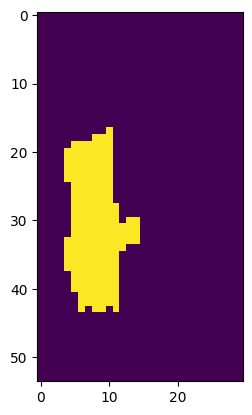

In [75]:
plt.imshow(x[189])
y[189]

Vamos a ver ejemplos de como ha funcionado nuestra división

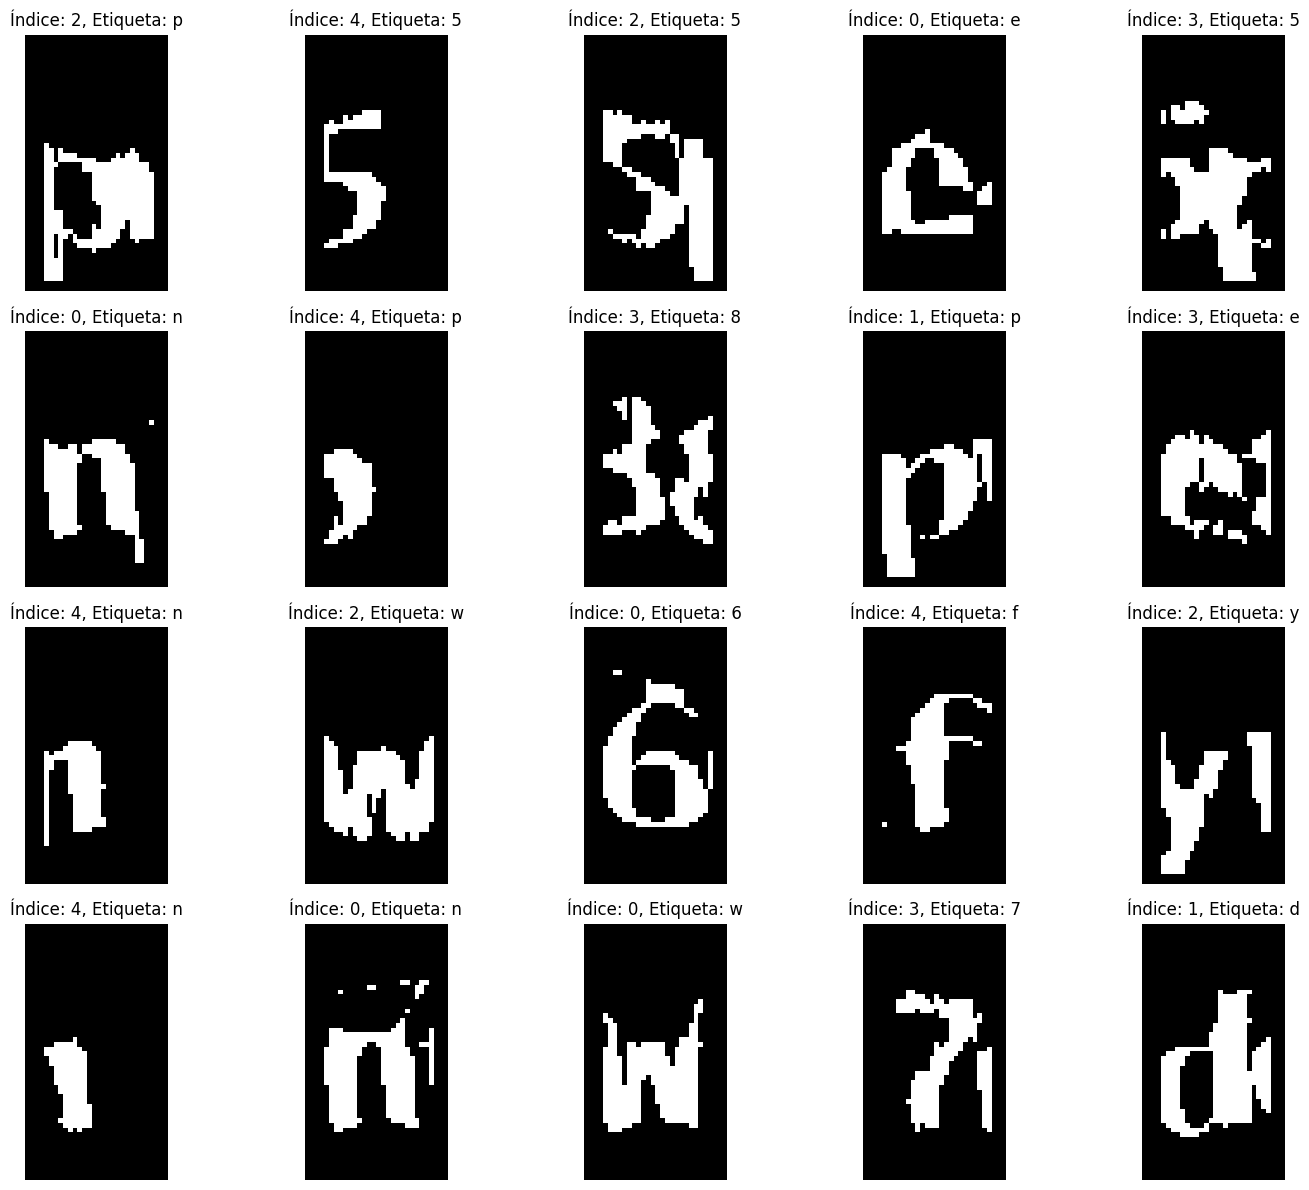

In [76]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Número de ejemplos a mostrar
num_examples = 20

# Genera índices aleatorios para seleccionar ejemplos
random_indices = random.sample(range(len(x)), num_examples)

# Configuración para la disposición de subplots
num_rows = 4  # Cambia esto según la cantidad de filas deseadas
num_cols = 5  # Cambia esto según la cantidad de columnas deseadas

# Crea una figura con subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    ax.imshow(x[idx], cmap='gray')
    ax.set_title(f'Índice: {idx%5}, Etiqueta: {y[idx]}')
    ax.axis('off')

# Asegura que los subplots vacíos no se muestren
for i in range(num_examples, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()
